In [12]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random 
from scipy.constants import c
from collections import defaultdict # default dict for initialization of edges

In [13]:
class SignalInformation ( object ): # lable of info the node stores in the Line class
    def __init__ (self,power,path):
        self._signal_power= power
        self._path= path
        self._noise_power= 0
        self._latency= 0
        self._indices = []  #indices for restoring the lightpath

    @property
    def signal_power (self):
        return self._signal_power

    @property
    def path (self):
        return self._path

    @path.setter
    def path (self, path):
        self._path= path

    @property
    def noise_power (self):
        return self._noise_power

    @noise_power.setter
    def noise_power (self, noise):
        self._noise_power = noise

    @property
    def latency (self):
        return self._latency

    @latency.setter
    def latency (self, latency):
        self._latency= latency
    def add_noise (self , noise):
        self.noise_power += noise
    def add_latency (self , latency):
        self.latency += latency # add latency
    def next (self): 
        self.path= self.path[1:] # path updating
        
    @property
    def indices (self):
         return self._indices   
    @indices.setter
    def add_index (self , index):
        self._indices. append(index)
    def pop_index (self , index):
        self._indices. pop(index)
        

In [14]:
class Lightpath (SignalInformation): # inheritance
    def __init__ (self,power,path):
        super().__init__(power,path) # give access to the methods in the sibbling 
        self._channel= 0
        
    @property
    def channel(self):
         return self._channel   
    @channel.setter
    def channel (self, channel):
        self._channel = channel


In [15]:
class Node ( object ): # we keep a dictionary of nodes in the Network
    def __init__ (self , node_dict ):
        self._label= node_dict ['label']
        self._position= node_dict ['position']
        self._connected_nodes= node_dict ['connected_nodes']
        self._successive= {}
        self._switching_matrix= None

    @property
    def label (self):
        return self._label

    @property
    def position (self):
        return self._position

    @property
    def connected_nodes (self):
        return self._connected_nodes
    
    @property
    def state (self):
        return self._state

    @property
    def successive (self): # link the node to the next one
        return self._successive

    @successive.setter
    def successive (self, successive ):
        self._successive = successive  

    def propagate (self, signal_information):
        path= signal_information.path
        if len( path ) >1: # if there exist a successive node
            line_label= path [:2]
            line= self.successive [line_label]
            signal_information.next () # scroll the nodes up to the last one
            signal_information= line.propagate (signal_information)
        return signal_information
    
    @property
    def switching_matrix (self): # link the node to the next one
        return self._switching_matrix

    @switching_matrix.setter
    def switching_matrix (self, switch_mat ):
        self._switching_matrix = switch_mat

In [16]:
class Line ( object ): # manage the signal informations for a dictionary in Network
    def __init__ (self , line_dict ):
        self._label= line_dict ['label']
        self._length= line_dict ['length']
        self._successive= {}
        self._state= ['free']*10 # initialize list of 10 free channels

    @property
    def label (self):
        return self._label

    @property
    def length (self):
        return self._length

    @property
    def successive (self):
        return self._successive
    
    @property
    def state (self):
        return self._state
    @state.setter
    def state (self, state):
        self._state= state

    @successive.setter
    def successive (self, successive ):
        self._successive= successive

    def latency_generation ( self ):
        latency= self.length / (c * 2 / 3)
        return latency

    def noise_generation (self, signal_power ):
        noise= 1e-9 * signal_power * self.length
        return noise

    def propagate (self, lightpath ):
        # Update latency
        latency = self.latency_generation ()
        lightpath.add_latency ( latency )
        # Update noise
        signal_power = lightpath.signal_power
        noise = self.noise_generation (signal_power)
        lightpath.add_noise (noise)
        node = self.successive [lightpath.path [0]]
        state = self.state
        if (type(lightpath) is Lightpath):#very important step*: refer to the generate_network method where we call propagate in order to build the weighted path dataframe
            #in that step we pass signal information , we donnt want to occupy the lines when building the first dataframe..
            #so we distinguish if the input of propagate is signal information(meaning building dataframe)or Lightpath(starting routing)
            index = lightpath.channel
            state[index] = 'occupied'
            self.state = state  # update the state of channels for this line before propagating
        lightpath = node.propagate (lightpath)
        return lightpath

In [17]:
class Connection( object ):
    def __init__(self, L1, L2, power, init_l=0, init_s=0): # attributes latency and snr initialized to zero
        self._input_node= L1    # string
        self._output_node= L2    # string
        self._signal_power= power # float
        self._latency= init_l
        self._snr= init_s
        
    @property
    def input_node (self):
        return self._input_node

    @property
    def output_node (self):
        return self._output_node

    @property
    def signal_power (self):
        return self._signal_power
    
    @property
    def latency (self):
        return self._latency
    @latency.setter
    def latency (self, latency):
        self._latency= latency
    def add_latency (self , latency):
        self.latency += latency # add latency
    
    @property
    def snr (self):
        return self._snr
    @snr.setter
    def snr (self):
        self._snr= snr
    def add_snr (self , snr):
        self._snr += snr # add snr 

In [34]:
class Network ( object ): # them main class that contains all the nodes and info
    def __init__ (self, json_path ):
        node_json = json.load ( open ( json_path ,'r'))
        self._nodes = {}
        self._lines = {}
        self._graph = {}
        
        for node_label in node_json:
            # Create the node instance
            node_dict = node_json [ node_label ]
            node_dict ['label'] = node_label
            node = Node ( node_dict )
            self._nodes [ node_label ] = node
            node.switching_matrix= node_dict ['switching_matrix']

            # Create the line instances
            for connected_node_label in node_dict ['connected_nodes']:
                line_dict ={}
                line_label = node_label + connected_node_label
                line_dict ['label'] = line_label
                node_position = np. array ( node_json [ node_label ]['position'])
                connected_node_position = np.array ( node_json [ connected_node_label ]['position'])
                line_dict ['length'] = np.sqrt (
                    np.sum (( node_position - connected_node_position )**2) #Pitagora distance formula
                    )
                line_dict['state']= ['free']*10 #default value
                line = Line ( line_dict )
                self . _lines [ line_label ] = line
                

    @property
    def nodes ( self ):
        return self._nodes 
    @property
    def lines ( self ):
        return self._lines
    def draw ( self ):
        nodes = self.nodes
        plt. figure ()
        for node_label in nodes :
            n0 = nodes [ node_label ]
            x0 = n0.position [0]
            y0 = n0.position [1]
            plt.plot (x0 ,y0 ,'go',markersize =10)
            plt.text (x0 +20 , y0 +20 , node_label )
            for connected_node_label in n0.connected_nodes :
                n1 = nodes [ connected_node_label ]
                x1 = n1. position [0]
                y1 = n1. position [1]
                plt.plot ([x0 ,x1 ] ,[y0 ,y1] ,'b')
        plt.title ('Network')
        plt. xlabel ('x amplitude [m]')
        plt. ylabel ('y amplitude [m]')
        plt.show ()    
        
    def find_paths (self ,label1 , label2 ):
        cross_nodes = [key for key in self.nodes.keys ()
                        if (( key != label1 ) & ( key != label2 ))]
        cross_lines = self.lines.keys ()
        inner_paths = {'0': label1 }
        for i in range (len ( cross_nodes )+1):
            inner_paths [str(i +1)] = []
            for inner_path in inner_paths [str (i)]:
                inner_paths [str(i +1)]+= [ inner_path + cross_node
                    for cross_node in cross_nodes
                    if (( inner_path [ -1]+ cross_node in cross_lines ) & ( cross_node not in inner_path ))]
        paths = []
        for i in range (len ( cross_nodes )+1):
            for path in inner_paths [str (i)]:
                if path [ -1] + label2 in cross_lines :
                    paths.append ( path + label2 )
        return paths
    
    def connect ( self ):               
        nodes_dict = self.nodes
        lines_dict = self.lines
        for node_label in nodes_dict :
            node = nodes_dict [ node_label ]
            for connected_node in node.connected_nodes :
                line_label = node_label + connected_node
                line = lines_dict [ line_label ]
                line.successive [ connected_node ] = nodes_dict [ connected_node ]
                node.successive [ line_label ] = lines_dict [ line_label ]  
        
    @property
    def graph ( self ):
        return self._graph # for now it is unlinked to graph = Connection()
    
    def network_generate ( self ):
        nodes_dict = self.nodes
        nodes_dict = self.connect ()
        node_labels = self.nodes.keys ()
        pairs = []
        for label1 in node_labels:
            for label2 in node_labels:
                if label1 != label2 :
                    pairs.append ( label1 + label2 )
        columns = ['path','latency','noise','snr']
        df = pd. DataFrame ()
        paths = []
        node1 = []
        node2 = []
        latencies = []
        noises = []
        snrs = []

        for pair in pairs :
            for path in self.find_paths ( pair[0] , pair[1]):
                path_string = ''
                node1.append (path[0])
                for node in path :
                    path_string += node + '->'
                paths.append ( path_string [: -2]) #create a pandas dataframe as "A->B-> ..."
                node2.append (node)

                # Propagation
                signal_information = SignalInformation (1e-3, path )
                signal_information = self.propagate( df, signal_information )
                latencies.append ( signal_information.latency )
                noises.append ( signal_information.noise_power )
                snrs.append (10* np.log10 (signal_information.signal_power / signal_information.noise_power))
        df['path'] = paths
        df['node1'] = node1
        df['node2'] = node2
        df['latency'] = latencies
        df['noise'] = noises
        df['snr'] = snrs
        return df
    
    def propagate (self, df, signal_info ):
        path = signal_info.path
        df = self.route_space( df )
        flag = 0
        for path_test in df.path:
            if path_test == path:
                break
            flag += 1 # to get the index of the path in the dataframe    
        ind = None
        availability_list = df['availability'] # get the availability channel list of the specified path in route_space
        try:
            ind = np.argmax(np.array(availability_list[flag]) > 0) # first available channel index
        except ValueError as ve: # if no available channel
            ind = f'Error Message = {ve}'
        if (ind == 'Error Message = substring not found'):
            signal_info.channel = -1 # no channel available, set it to -1
        else:
            signal_info.channel = ind # assign this channel to the lightpath
        start_node = self.nodes [ path [0]]
        signal_info=start_node.propagate (signal_info)
        signal_info.path=path
        
        ind_min1 = ind-1
        ind_plus1 = ind+2
        if ind==0:
            ind_min1 = ind
        if ind==len(df['availability'][flag])-1:
            ind_plus1 = ind+1
        # we decrease the lightpath ch and the 2 adjacents ones    
        df['availability'][flag][ind_min1:ind_plus1] = [x-1 for x in df['availability'][flag][ind_min1:ind_plus1]]
        signal_info.add_index= ind
        return signal_info
    
    def lightpath_restore ( self , lightpath ):
        path = lightpath.path
        flag = 0
        for path_test in df.path:
            if path_test == path:
                break
            flag += 1 # to get the index of the path in the dataframe    
        ind = None 
        
        ind=lightpath.indices.pop()
        ind_min1 = ind-1
        ind_plus1 = ind+2
        if ind==0:
            ind_min1 = ind
        if ind==len(df['availability'][flag])-1:
            ind_plus1 = ind+1
        # we increase the lightpath ch and the 2 adjacents ones    
        df['availability'][flag][ind_min1:ind_plus1] = [x+1 for x in df['availability'][flag][ind_min1:ind_plus1]]
        lightpath.pop_index= ind
        return lightpath
    

      
    def route_space (self, df):
        self.connect ()
        node_labels = self.nodes.keys ()
        nodes_dict= self.nodes
        pairs = []
        lines_dict = self.lines

        for label1 in node_labels:
            for label2 in node_labels:
                if label1 != label2 :
                    pairs.append ( label1 + label2 )
        columns = ['path','availability']
        paths = []

        for pair in pairs :
            for path in self.find_paths ( pair[0] , pair[1]):
                path_string = ''
                for node in path :
                    path_string += node 
                paths.append ( path_string ) #create a pandas dataframe as "AB ..."

       
        df['path'] = paths # instead of recomputing all the paths just remove the delimeter"=>" since then we need to compare it with lightpath path
        availability=[]
        for path in paths:
            av = []
            for i in range (0,10):# to fill the availability list for each path
                for ll in range (0,len(path)-1):
                    line_label= path[ ll:ll+2 ]
                    line = lines_dict[line_label]
                    #line_check = Line(line)
                    if (line.state[i]!='free'): #if at least one line of the path have the ith channel occupied
                        av.append(0)
                        break
                else :
                    av.append(1) # loop didn't break so the channel is available over this path
                    
            flag=1
            for node_labell in path[1:-1]: # get node labels of the path excluding the initial and last nodes
                node=nodes_dict[ node_labell ]
                #print(path, node_labell,path[flag-1],path[flag+1])
                block=node.switching_matrix [ path[flag-1] ][ path[flag+1] ] # get switching_matrix [’in_node ’][ ’out_node ’]
                flag+=1
                av= np.multiply(np.array(av),np.array(block)) # multiplication of the path availability through lines and the blockage
                                                              # of each node of the path (blockage taken from switching matrix)
            availability.append(av)
        df['availability']= availability
        return df
        
    
    def find_best_snr( self ,Label1 , Label2):
        index = []
        snrs = [] #list of all the snr from lable1 to lable2
        for ii in range(0, len(df.path)-1):
            if((df.node1[ii]==Label1) & (df.node2[ii]==Label2)):
                path = df.path[ii]
                path_availability = df.availability[ii]
                for kk in range(0,9):
                     if(path_availability[kk]== 1):# the kkth channel is available on this path
                            index.append(ii)# save the indexes of collected paths
                            snrs.append(df.snr[ii])
                            break # as soon as i find an available path get out from the loop   
                
        if not snrs: #no avaible paths, snr set to zero
            snr=0
        else:
            snr= max(snrs) #get highest snr in first place
            ind= np.argmax(snrs)
        if snr != 0:
            path_index= index[snrs.index(snr)]# get the index of the path with best snr
            return [df.loc[path_index,'path'],df.latency[[index[ind]]],snr] # return path, relative latency and best snr
        else :
            return 0
    
    def find_best_latency( self ,Label1, Label2):
        index = []
        lats=[] #list of all the latency from lable1 to lable2
        for ii in range(0, len(df.path)-1):
            if((df.node1[ii]==Label1) & (df.node2[ii]==Label2)):
                path = df.path[ii]
                path_availability = df.availability[ii]
                for kk in range(0,9):
                     if(path_availability[kk]== 1):# the kkth channel is available on this path
                            lats.append(df.latency[ii])
                            index.append(ii)
                            break 
        
        if not lats:#no avaible paths, lat set to None
            lat='None'
        else:
            lat= min(lats) #get lowest latency in first place
            ind= np.argmin(lats)
        if lat != 'None':
            path_index= index[lats.index(lat)]# get the index of the path with best latency
            return [df.loc[path_index,'path'],lat,df.snr[index[ind]]] # return path, minimum latency and relative snr
        else :
            return 'None'

    
    def stream (self, df, conn_list, index, label):
        df= self.route_space( df )
        av = df.availability
        if (label=='lat') :
            tuple= self.find_best_latency( conn_list[index].input_node, conn_list[index].output_node)#return the available path in routing space with best latency    
            if tuple != 'None':
                path = tuple[0] # tuple [0:2] return path, lat, snr
            else: 
                return 'None'
        else:
            tuple= self.find_best_snr( conn_list[index].input_node, conn_list[index].output_node)
            if tuple != 0:
               path = tuple[0] # tuple [0:2] return path, lat, snr
            else:
                return 0
        
        # Propagation
        lightpath= Lightpath (conn_list[index].signal_power , path )
        lightpath= self.propagate ( df, lightpath ) #inside propagate we got the availbale channel and we update this channel state of all lines of the path
            #(after propagating the lightpath through all lines we have to update the route_space
            #for which updating the availability for all paths containing all lines of the previous path 
        channel = lightpath.channel #must check if channel != -1
        if channel == -1 :
            return 'None'# no available channels for this connection
        else: 
            for ii in range(0,len(path)-2):
                if len(path)>1:
                    line_label= path [ii:ii+2]
                    for paths in df.path:
                        index=0 # to keep track on which line we need to modify in the dataframe
                        if(any (line_label in string for string in paths)):# all pths containing a line from the previous path
                            A=np.array(av[index]) #get the availability at that index
                            A[channel] = 0 #update the corresponding channel availability of this path
                            new_df = pd.DataFrame({'availability': [A]}, index =[index])
                            df.update(new_df)
                        index+=1   
        lightpath= self.lightpath_restore ( lightpath )
        if (label=='lat') :
            return tuple[1]
        else:
            return tuple[2]

In [35]:
network = Network ('nodes_full.json')
df = network.network_generate()
node_labels= network.nodes.keys ()
labels_list=list(node_labels)

random.seed(15)
conn_list= []
tries=0
while tries<=100:
    index_in= np.random.randint(0,5) #100 random in_path A-F
    Label1=labels_list[index_in]     
    index_out= np.random.randint(0,5) #100 random out_path A-F
    Label2=labels_list[index_out]
    power= np.random.random()*1e-3 #powers are 100 float numbers between 0 and 1e-3
    if ( Label1 != Label2 ) : #make sure no same input output labels
        conn_list.append( Connection( Label1 , Label2, power) ) #list creation
        tries+=1

stream_try1= np.array([])
for ii in range(100) :
    Lat=network.stream (df, conn_list, ii,'lat')
    if Lat!='None':
    stream_try1=np.append(stream_try1,Lat)

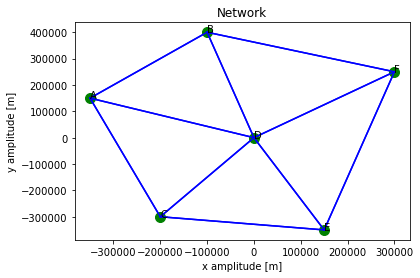

In [59]:
network = Network ('nodes_not_full.json')
df = network.network_generate()

stream_try2= np.array([])
for ii in range(100) :
    Lat=network.stream (df, conn_list, ii,'lat')
    if Lat!='None':
        stream_try2=np.append(stream_try2,Lat)
    
network.draw() # draw the network using matplotlib (nodes as dots and connection as lines)

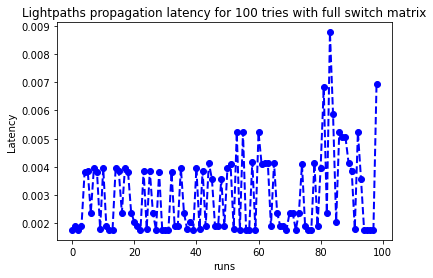

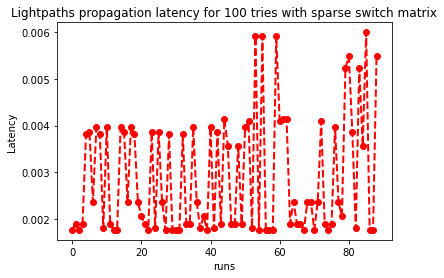

In [60]:
plt. figure ()
plt. plot( stream_try1, color ='b', marker ='o', markerfacecolor ='b',linestyle ='--', linewidth =2)
plt. title  ('Lightpaths propagation latency for 100 tries with full switch matrix')
plt. xlabel ('runs')
plt. ylabel ('Latency')

plt.savefig('Lab7_full_mat.png')
plt. show()

plt. figure ()
plt. plot( stream_try2, color ='r', marker ='o', markerfacecolor ='r',linestyle ='--', linewidth =2)
plt. title  ('Lightpaths propagation latency for 100 tries with sparse switch matrix')
plt. xlabel ('runs')
plt. ylabel ('Latency')

plt.savefig('Lab7_not_full_mat.png')
plt. show()